In [1]:
import importlib
import torch
import datafawn
importlib.reload(datafawn)

from pathlib import Path

# Check GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("CUDA not available, using CPU")


Using GPU: NVIDIA GeForce RTX 5070 Ti Laptop GPU


In [2]:
# =============== POSE ESTIMATOR =============== #
dlc_estimator = datafawn.DeepLabCutPoseEstimator(
    model_name='superanimal_quadruped',
    detector_name='fasterrcnn_resnet50_fpn_v2',
    hrnet_model='hrnet_w32',
    max_individuals=1,
    pcutoff=0.15,
    device=device
)

# =============== POSTPROCESSORS =============== #
rel_paws = ['front_left_paw_rel', 'front_right_paw_rel', 'back_left_paw_rel', 'back_right_paw_rel']
reference_map = {
    'back_base': ['front_left_paw', 'front_right_paw'],
    'tail_base': ['back_left_paw', 'back_right_paw']
}

rel_pp = datafawn.RelativePawPositionPostprocessor()
error_pp = datafawn.ErrorPostprocessor(
    bodyparts=rel_paws,
    use_velocity=True,
    use_likelihood=True,
    use_distance=True,
    velocity_kwargs={'threshold_pixels': 50, 'window_size': 5},
    likelihood_kwargs={'min_likelihood': 0.5},
    distance_kwargs={'reference_map': reference_map, 'max_distance': 300}
)

# =============== EVENT EXTRACTOR =============== #
zeni_extractor = datafawn.ZeniExtractor(
    smooth_window_size=5,
    prominence_percentage=0.05,
    orientation_likelihood_threshold=0.0,
    orientation_smooth_window_size=15,
    show_plots=False
)

# =============== SOUNDSCAPE GENERATOR =============== #
ss_auto = datafawn.SoundScapeAuto(
    notes_folder='sounds/custom_tone',
    std_dev=3, 
    speed_threshold=20,
    backing_track_path='sounds/rev_backing_2.wav',
    backing_track_base_volume=0.05,
    backing_track_max_volume=0.8,
    backing_track_volume_curve=4.0,
    show_speed_plot=True,
    )

In [3]:
# Create the FULL pipeline with all components
pipeline = datafawn.EventDetectionPipeline(
    pose_estimator=dlc_estimator,
    postprocessors=[rel_pp, error_pp],
    event_extractors=[zeni_extractor],
    # soundscape_generators=[ss_generator]
    soundscape_generators=[ss_auto]
)

In [4]:
# # Run full pipeline from raw video
# RAW_VIDEO_PATH = 'data/raw_videos/inspo_tiktok.mov'
# OUTPUT_DIR = 'data/tiktok'

# results = pipeline.run(
#     video_path=RAW_VIDEO_PATH,
#     output_dir=OUTPUT_DIR,
#     soundscape_input_video="pose_est"  # Use the labeled video for soundscape
# )

Loading video: data\tiktok\pose_estimation\inspo_tiktok_superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2__labeled_before_adapt.mp4
Video FPS: 30.0
Video duration: 28.07 seconds
Loaded 21 back feet notes, 21 front feet notes

SPEED ARRAY STATISTICS
Duration: 24.7 seconds (740 frames)
Min:  2.00 footfalls/window
Max:  28.00 footfalls/window
Mean: 15.68 footfalls/window
Std:  5.74

Percentiles (for threshold guidance):
  25th percentile: 12.00
  50th percentile: 16.00
  75th percentile: 20.00
  90th percentile: 23.00
  95th percentile: 24.00

Time above threshold:
  >= 2: 100.0% of video
  >= 4: 98.5% of video
  >= 6: 94.3% of video
  >= 8: 90.7% of video
  >= 10: 85.4% of video



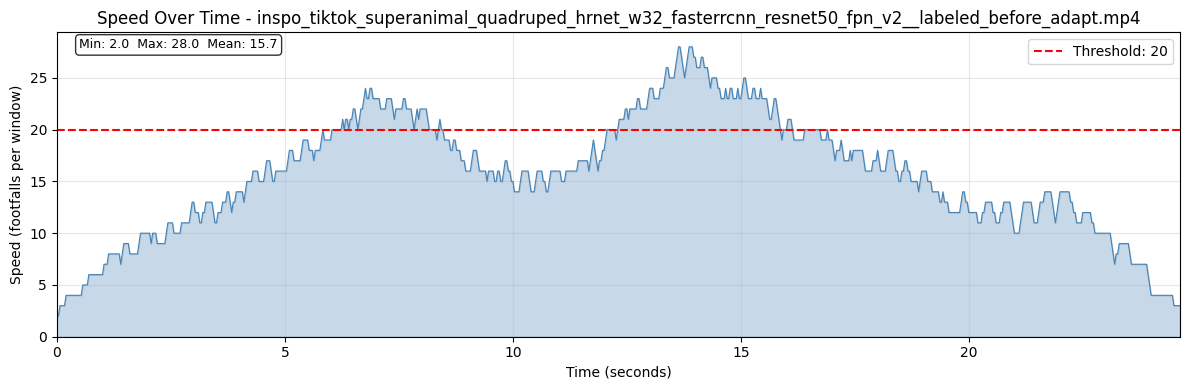


Processing individual: animal0 (scorer: superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2_)
    back_right_paw_strike: 61 clips, 22 reversed
    back_left_paw_strike: 59 clips, 24 reversed
    front_left_paw_strike: 52 clips, 21 reversed
    front_right_paw_strike: 57 clips, 22 reversed

Total audio clips created: 229

Processing backing track (volume: 0.1x - 0.8x at speed>=20.0)
Loading backing track: sounds\rev_backing_2.wav
  Duration: 58.28s, Sample rate: 44100Hz
  Cropping to 28.07s
  Volume scaling: curve=4.0, threshold=20
  Volume range: 0.05x - 0.80x (mean: 0.37x)
  Speed-scaled backing track ready: 28.07s
Adding backing track: 28.07s

Compositing 230 audio clips...

Writing output video to: data\tiktok\soundscapes\SoundScapeAuto_output.mp4
MoviePy - Building video data\tiktok\soundscapes\SoundScapeAuto_output.mp4.
MoviePy - Writing audio in SoundScapeAuto_outputTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
MoviePy - Writing video data\tiktok\soundscapes\SoundScapeAuto_output.mp4



MoviePy - Done !
MoviePy - video ready data\tiktok\soundscapes\SoundScapeAuto_output.mp4
Done! Output saved to: data\tiktok\soundscapes\SoundScapeAuto_output.mp4
📁 Saved soundscape: data\tiktok\soundscapes\SoundScapeAuto_output.mp4


In [5]:
# Partial pipeline after events are extracted
results = pipeline.run(
    events_path='data/tiktok/events/events.json',
    output_dir='data/tiktok/',
    soundscape_input_video='data/tiktok/pose_estimation/inspo_tiktok_superanimal_quadruped_hrnet_w32_fasterrcnn_resnet50_fpn_v2__labeled_before_adapt.mp4'
)